This notebook was writen in python 3.11 using qiskit 1.2.4 and qiskit-aer 0.15.1.

The quantum adder x+y mod N presented in the lecture works only for $x+y<2N$, because the modulo operation was handeld by subtracting N once when x+y>N. To make the ciruict function for arbitrary x,y, N note that:
$$
(x+y)\mod{N} = (x \mod{N} +y \mod{n}) \mod{N}
$$
So the design from the lecture can be used, if x and y are already $\mod{N}$, because  $(x \mod{N} +y \mod{N}) <2N$ and the circuit addes them mod N by design. 

However I was not able to construct a circuit to do the mapping $|x\rangle \to | x \mod{N}\rangle$ for ___arbitrary___ $x$ only containing elementary gates. Therefore I opted for a dynammic circuit design, using a feed forward loop and subtract $N$ from $x$ until $x<N$ (see [Cell](#modN)). Note that this circuit dosn't do any classical arithmetic and could in principle run on IBM Quantum Hardware. 

In [1]:
import qiskit.visualization
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT
import numpy as np
from qiskit_aer import AerSimulator


In [2]:
def sim(circuit, simulator, shots,x_val,y_val,N,n_qubits):
    display(qiskit.visualization.plot_distribution(simGetCounts(circuit, simulator, shots,), title=rf" {x_val}+{y_val} mod {N} = ${(x_val+y_val)%N }_{{10}}$ = ${((x_val+y_val)%N):0{n_qubits}b}_{{2}}$ "))

def simGetCounts(circuit, simulator, shots):
    return simulator.run(qiskit.transpile(circuit, simulator),shots=shots).result().get_counts(0)

In [3]:
def qft_adder(y_val,x):
    qc = QuantumCircuit(*x,name="qftAdd")
    # Apply QFT 
    qft = QFT(qc.num_qubits, do_swaps=False)
    qc.append(qft,qc.qubits[:] )
    
    # Apply controlled phase rotations
    for i in range(qc.num_qubits):
            theta = 2 * np.pi*y_val / (2 ** (i + 1))
            qc.p(theta, qc.qubits[i])
    # Apply inverse QFT 
    iqft = QFT(qc.num_qubits, do_swaps=False).inverse()
    qc.append(iqft, qc.qubits[:])
    
    return qc.to_instruction()

In [4]:
def Cqft_adder(y_val,c1,x):
    """
        assuming the first Quantum register is the x+1-register, and the second  is c1, third is c2
    """

    qc = QuantumCircuit(x,c1 ,name="CqftAdd")
    # Apply QFT 
    qft = QFT(qc.num_qubits -len(c1), do_swaps=False)
    qc.append(qft,qc.qubits[:-1] )
    
    # Apply controlled phase rotations
    for i in range(qc.num_qubits -len(c1)):
            theta = 2 * np.pi*y_val / (2 ** (i + 1))
            qc.cp(theta,c1[0], qc.qubits[i])
    # Apply inverse QFT 
    iqft = QFT(qc.num_qubits -len(c1), do_swaps=False).inverse()
    qc.append(iqft, qc.qubits[:-1])
    
    return qc.to_instruction()

In [5]:
def isless( y_val, a,c1,x):
    qc = QuantumCircuit(x,a,c1,name="isLess")
    qc.append(qft_adder(-y_val,[x,a]),[*x,a])
    qc.cx(a,c1)
    qc.append(qft_adder( +y_val,[x,a]),[*x,a])
    return qc.to_instruction()


In [6]:
def modNWithoutCircuit(x_val,N,n_qubits):
    x = QuantumRegister(n_qubits,'x')
    a = QuantumRegister(1,'a')
    c = QuantumRegister(1,'c')
    clss_c1 = ClassicalRegister(1,'class_c')
    clss = ClassicalRegister(n_qubits)  # Classical bit to store the c measurement 
    qc = QuantumCircuit(x, a, c,clss,clss_c1,name ="x+y mod N")
    for i in range(n_qubits):
        if (x_val & (1 << i)):
            qc.x(qc.qubits[i])
    qc.append(isless(N,a,c,x),[*x,*a,*c])
        # qc.x(x)
    qc.measure(c[0],clss_c1[0])
    with qc.while_loop((clss_c1[0],0)):
        qc.append(qft_adder(-N,[x]),x)
        qc.append(isless(N,a,c,x),[*x,*a,*c])
        qc.measure(c[0],clss_c1[0])
    qc.measure(x,clss)

    
    return qc

<a id='modN'></a>

In [7]:
def modN(N,n_qubits):
    x = QuantumRegister(n_qubits,'x')
    a = QuantumRegister(1,'a')
    c = QuantumRegister(1,'c1')
    clss_c1 = ClassicalRegister(1,'class_c') 
    qc = QuantumCircuit(x, a, c,clss_c1,name ="x+y mod N")
    qc.append(isless(N,a,c,x),[*x,*a,*c])
        # qc.x(x)
    qc.measure(c[0],clss_c1[0])
    with qc.while_loop((clss_c1[0],0)):
        qc.append(qft_adder(-N,[x]),x)
        qc.append(isless(N,a,c,x),[*x,*a,*c])
        qc.measure(c[0],clss_c1[0])
    # qc.measure(x,clss)

    
    return qc

In [8]:
def get_circuit(x_val,n_qubits):
    x = QuantumRegister(n_qubits,'x')
    a = QuantumRegister(1,'a')
    a1 = QuantumRegister(1,'a1')
    c1 = QuantumRegister(1,'cnt')
    c2 = QuantumRegister(1,'cnt1')
    clss_c1 = ClassicalRegister(1,'class_c')

    clb = ClassicalRegister(n_qubits)
    qc = QuantumCircuit(x,a,a1,c1,c2,clb,clss_c1)
    for i in range(n_qubits):
        if (x_val & (1 << i)):
            qc.x(qc.qubits[i])
    return qc

Some comments on the `addmodN` operation: The operation $x \mod{n}$ is done on the register it self. For $y$ the $\mod{N}$ operation is done on an extra circuit, it gets simualted and read out to a classical value, and used for further computation. 

Note that one can also use $n_y$ additional qubits and proceed similar to $x$.The additon of the two register is than analogous to the last sheet. For the sake of clarity I decided against this approce.  (I hope thats ok)

In [9]:
def addmodN(y_val,N,n_qubits):
    x = QuantumRegister(n_qubits,'x')
    a = QuantumRegister(1,'a')
    a1 = QuantumRegister(1,'a1')
    c1 = QuantumRegister(1,'cnt')  
    c2 = QuantumRegister(1,'cnt1')  
    clss_c1 = ClassicalRegister(1,'class_c')
    qc = QuantumCircuit(x, a,a1, c1,c2,clss_c1,name ="x+y mod N")
    qc =qc.compose(modN(N,n_qubits),[*x,*a1,*c2],clss_c1)

    # without y mod N this code will work only for x+y<2N
    n_qubits_y = int(np.ceil(np.log2(y_val)+1))
    qcFory = modNWithoutCircuit(y_val,N,n_qubits_y)
    y_val = int(list(simGetCounts(qcFory,AerSimulator(),100))[0][-n_qubits:],2)
    qc.append(isless(N-y_val,a,c1,x),[*x,*a,*c1])
    qc.append(qft_adder(y_val,[x]),x)
    qc.x(c1)
    qc.append(Cqft_adder(-N, c1,x), [*x,*c1])
    
    return qc

In [10]:
x_val =9
y_val = 112
N_val=6
# ensures that x register is large enough to fit arbitrary mod N operation
n_qubits = max(int(np.ceil(np.log2(x_val)+1)),int(np.ceil(np.log2(N_val)+1)) ) 


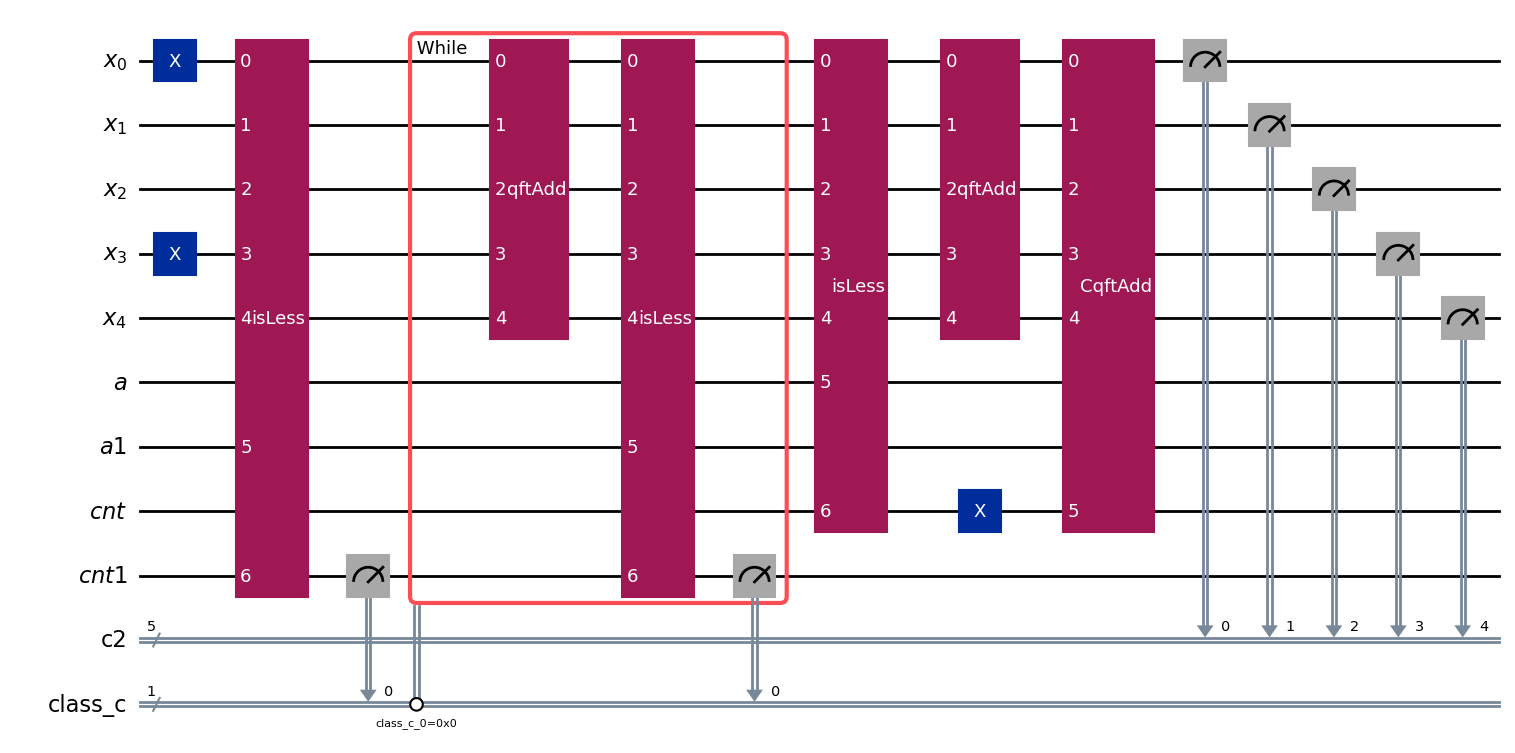

In [13]:
# rerun this cell if the execution fails on the first run
circuit = get_circuit(x_val,n_qubits)
circuit.compose(addmodN(y_val,N=N_val,n_qubits=n_qubits),circuit.qubits[:],[*circuit.cregs[1],],inplace=True)

circuit.measure(circuit.qregs[0][:],circuit.cregs[0][:n_qubits])
# circuit.measure(circuit.qregs[1][0],circuit.cregs[0][-1])
circuit.draw('mpl')


The seperate bit upfront in the reuslt is the class_c bit used in the feed forward loop, i wasn't able to hide it.

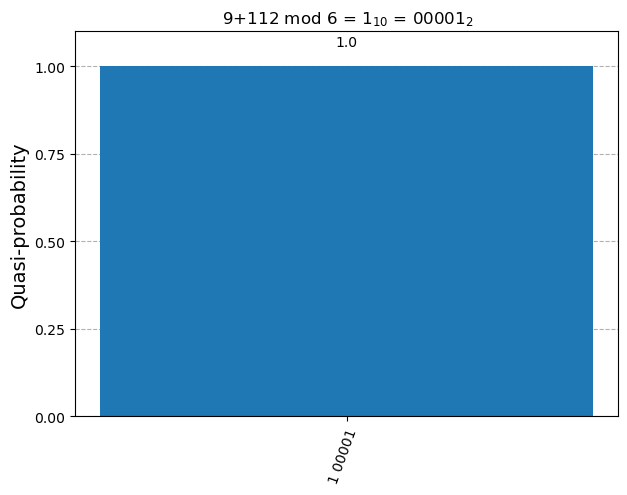

In [14]:
sim(circuit,AerSimulator(),10,x_val,y_val,N_val,n_qubits)